In [2]:
!ls

Answer1.xlsx                        Train1.csv
Answer2.xlsx                        Train2.csv
RFT.RAR                             UnderstandThingsBeforeDoingIt.ipynb
Test1.csv                           Untitled.ipynb
Test2.csv                           hackathon


In [3]:
import pandas as pd
import keyword
import numpy as np
from matplotlib import pyplot as plt

In [4]:
df = pd.read_csv('Train2.csv')

In [5]:
df = df.dropna()
df.columns = df.columns \
    .str.strip() \
    .str.lower() \
    .str.replace(' ', '_') \
    .str.replace('(', '') \
    .str.replace(')', '') \
    .str.replace('-','_') \
    .map(lambda x: 'x'+x if x in keyword.kwlist else x )

In [6]:
df.columns

Index(['testid', 'wellid', 'depthmd', 'depthtvdss', 'temp', 'gr',
       'resist_deep', 'resist_medium', 'resist_short', 'density', 'neutron',
       'fluidtype', 'subblock', 'thickness', 'reservior', 'mobility'],
      dtype='object')

In [7]:
cols = ['temp','gr','resist_short','density','neutron','thickness']

In [8]:
reduced = df[cols]

train_mask = np.random.random(len(reduced))<0.7
test_mask = ~train_mask

reduced_test = reduced[test_mask]
reduced = reduced[train_mask]

target = df.mobility[train_mask]
target_test = df.mobility[test_mask]


In [9]:
def compare_plot(predicted, actual): #log predicted vs log actual
    plt.plot(predicted, actual, '.')
    plt.ylim(-2, 10)
    plt.xlim(-2, 10)
    xxs = np.linspace(0,5)
    plt.xlabel('log(predicted)')
    plt.ylabel('log(actual)')
    plt.plot(xxs, xxs)
    
def compare_raw_plot(predicted, actual): #log predicted vs log actual
    plt.plot(predicted, actual, '.')
    plt.ylim(0, np.exp(6))
    plt.xlim(0, np.exp(6))
    xxs = np.linspace(0,np.exp(6))
    plt.xlabel('predicted')
    plt.ylabel('actual')
    plt.plot(xxs, xxs)
    
def mse_loss(predicted, actual):
    return np.std(predicted - actual)

def plot_residual(predicted, ys, predicted_test, ys_test):
    plt.figure()
    plt.title('Residual of log')
    res = predicted - ys
    plt.hist(res, bins=np.linspace(-8,8, 30), label='Train', density=True, alpha=0.5)
    res_test = predicted_test - ys_test
    plt.hist(res_test, bins=np.linspace(-8,8, 30), density=True, alpha=0.5)
    print('Train Residual', 'mean=', np.mean(res), 'std=', np.std(res))
    print('Test Residual', 'mean=', np.mean(res_test), 'std=', np.std(res_test))
    return res, res_test

train loss 1.622135896297239
[('w0', 41.14155103369143), ('temp', -5.83185601300106), ('gr', -2.348141647386607), ('resist_short', 0.049811961631198304), ('density', 0.5377926737725773), ('neutron', 1.7774943051532353), ('thickness', 0.1387423248942352)]
test loss 1.567854333568469
train raw loss 214.73032914431758
test raw loss 222.83913155776543
Train Residual mean= -4.061504349610989e-08 std= 1.622135896297239
Test Residual mean= -0.1246640342636417 std= 1.567854333568469
4.796345786814595
Expected Offset4.796345786814595times


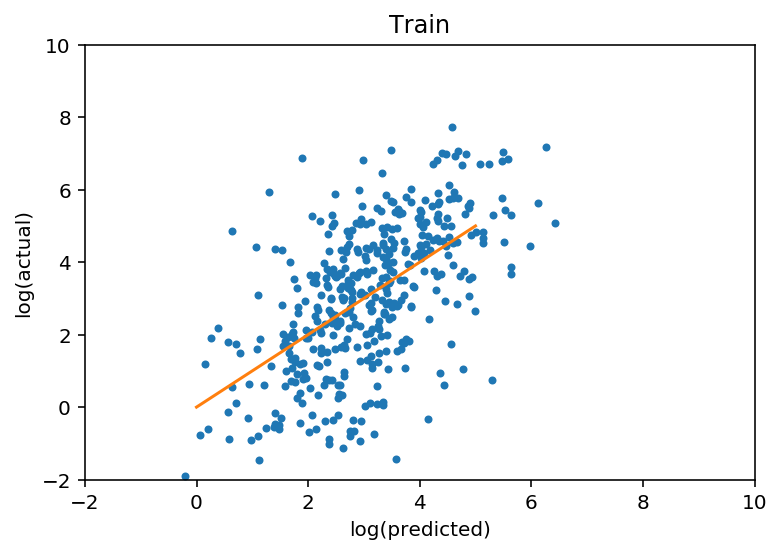

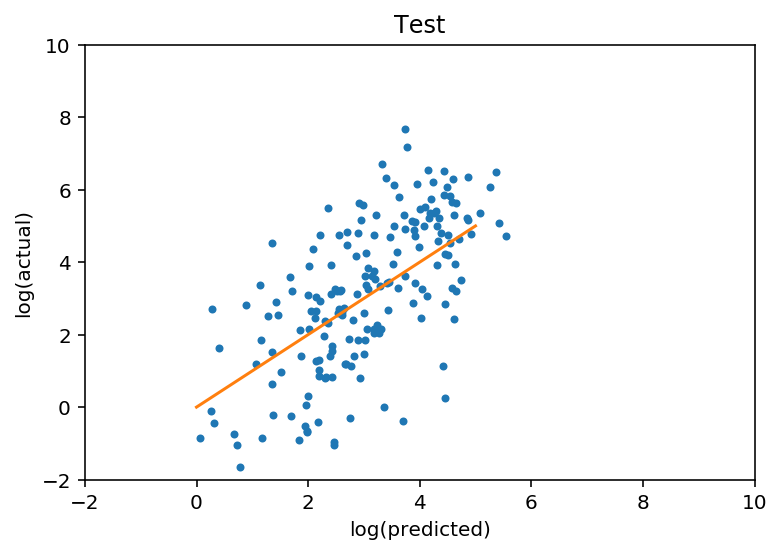

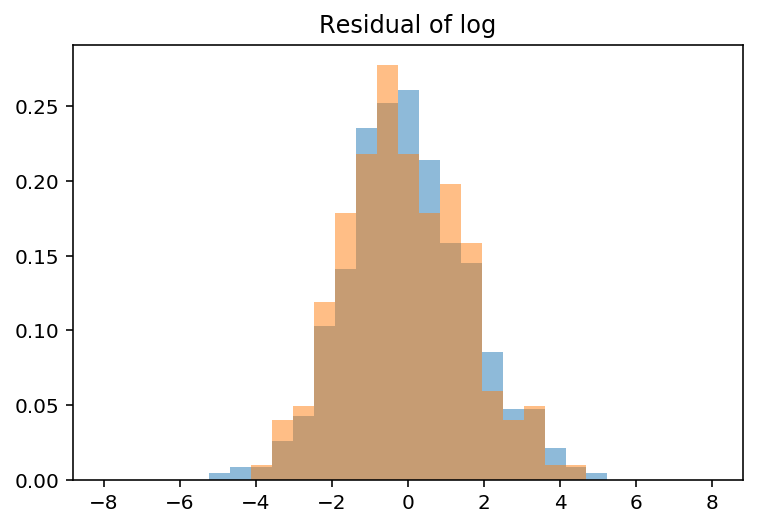

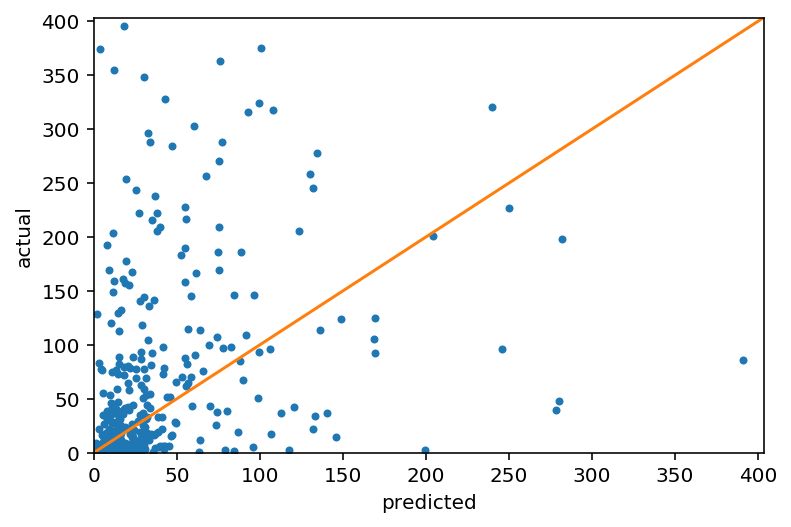

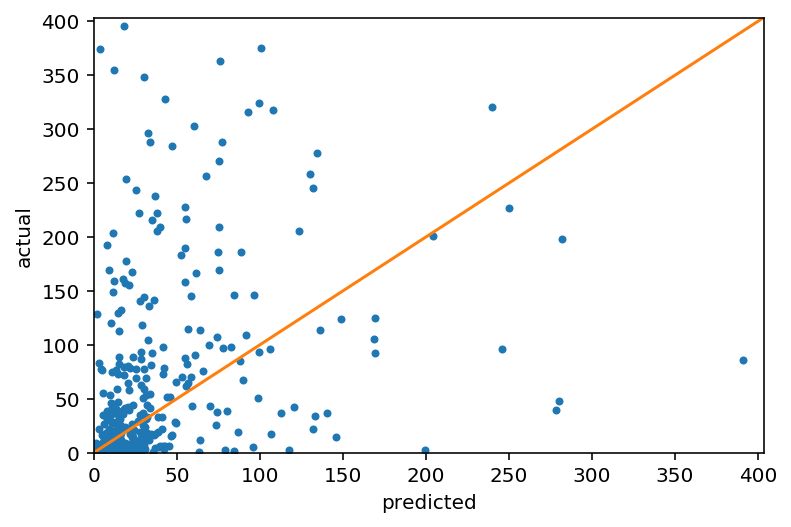

In [16]:
###!!!!!Sunny use this!!!

#try log linear # Motivation power law

def prepare(original):    
    xs = np.log(original)
    padder = [[1]]*len(xs)
    xs = np.hstack((padder, xs))
    return xs



xs = prepare(reduced.values)
ys = np.log(target.values)

def cost(w):
    return np.sum((ys - np.dot(xs, w))**2)

nw = len(xs[0])

from scipy.optimize import minimize
np.random.seed(999)
res = minimize(cost, np.random.randn(nw))

predicted = np.dot(xs, res.x)
plt.title('Train')
compare_plot(predicted, ys)

print('train loss', mse_loss(predicted, ys))

plt.figure()
ys_test = np.log(target_test.values)
xs_test = prepare(reduced_test)
predicted_test = np.dot(xs_test, res.x)
print(list(zip(['w0']+cols, res.x)))

print('test loss', mse_loss(predicted_test, ys_test))
plt.title('Test')
compare_plot(predicted_test, ys_test)

print('train raw loss', mse_loss(np.exp(predicted), np.exp(ys)))
print('test raw loss', mse_loss(np.exp(predicted_test), np.exp(ys_test)))

res, res_test = plot_residual(predicted, ys, predicted_test, ys_test)
print(np.exp(np.std(res_test)))

print('Expected Offset'+ repr(np.exp(np.std(res_test))) + 'times')

plt.figure()
compare_raw_plot(np.exp(predicted), np.exp(ys)) #log predicted vs log actual
plt.figure()
compare_raw_plot(np.exp(predicted), np.exp(ys)) 



# plt.figure()
# plt.title('Residual')
# plt.hist(predicted - ys, bins=np.linspace(-8,8, 30), label='Train', density=True, alpha=0.5)
# plt.hist(predicted_test - ys_test, bins=np.linspace(-8,8, 30), density=True, alpha=0.5)

train loss 1.524890395191598
test loss 1.4943389876581386
train raw loss 65.53103709564853
test raw loss 61.40822717385473


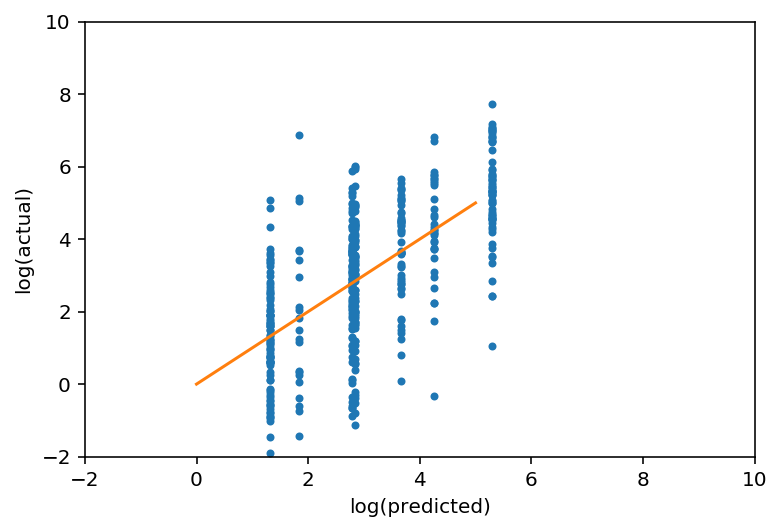

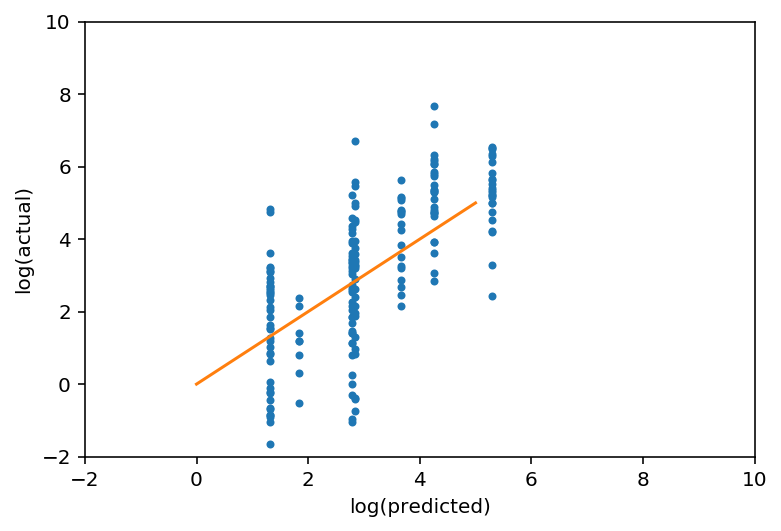

In [12]:
#try log linear with treeregressor

def prepare(original):    
    xs = np.log(original)
    return xs

xs = prepare(reduced)
ys = np.log(target)

from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor('mse', min_samples_split=100)
tree.fit(xs, ys)
predicted = tree.predict(xs)
compare_plot(predicted, ys)
print('train loss', mse_loss(predicted, ys))



plt.figure()
ys_test = np.log(target_test)
xs_test = prepare(reduced_test)
predicted_test = tree.predict(xs_test)
compare_plot(predicted_test, ys_test)
print('test loss', mse_loss(predicted_test, ys_test))


print('train raw loss', mse_loss(np.exp(predicted), ys))
print('test raw loss', mse_loss(np.exp(predicted_test), ys_test))




/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in log
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in log
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in log
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in log


train log loss nan
test log loss nan
train raw loss 213.31209997490095
test raw loss 216.46263116350866
Train Residual mean= nan std= nan
Test Residual mean= nan std= nan
nan


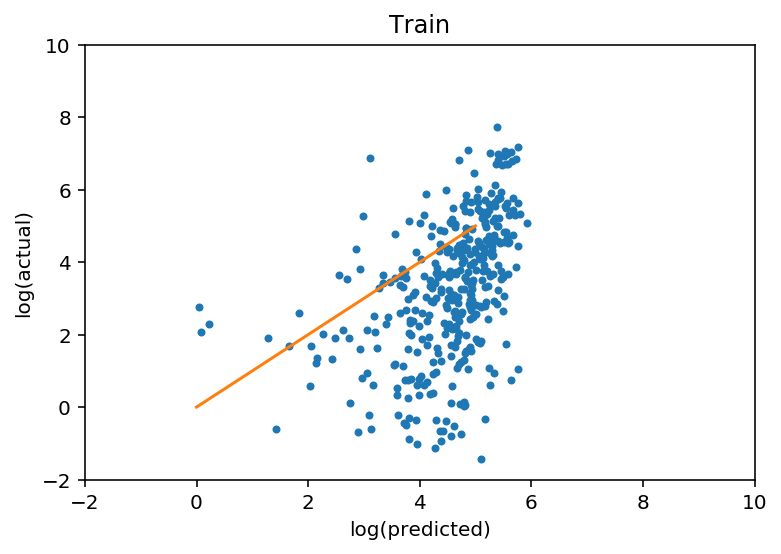

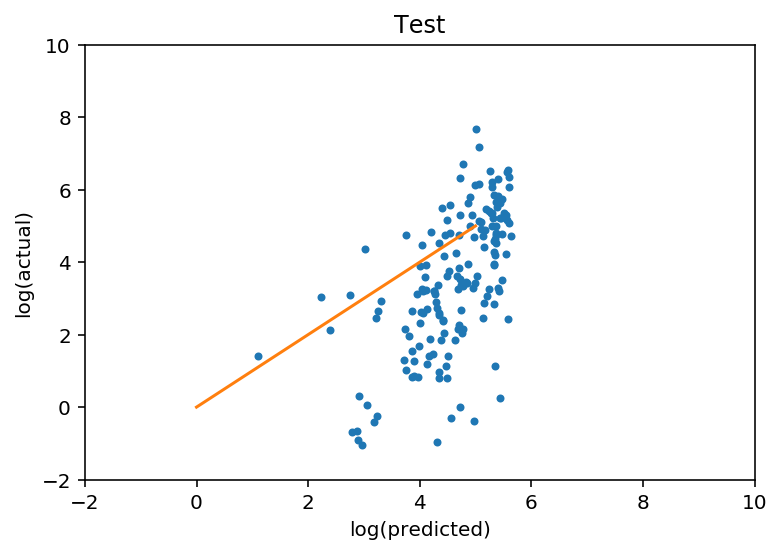

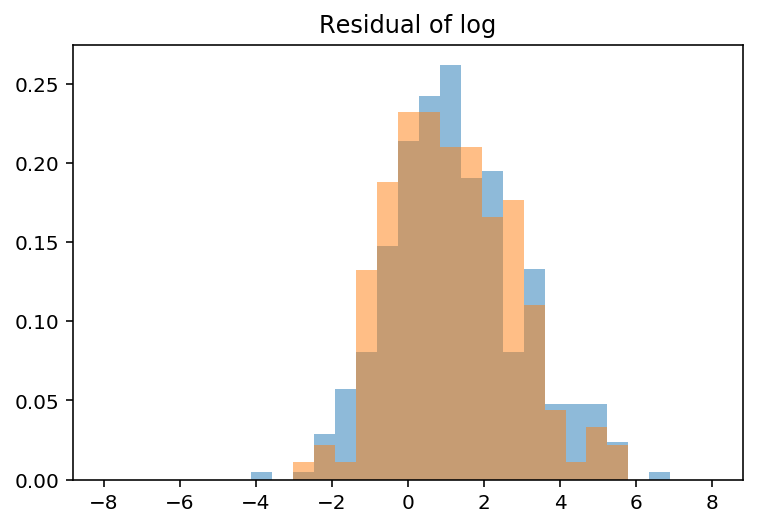

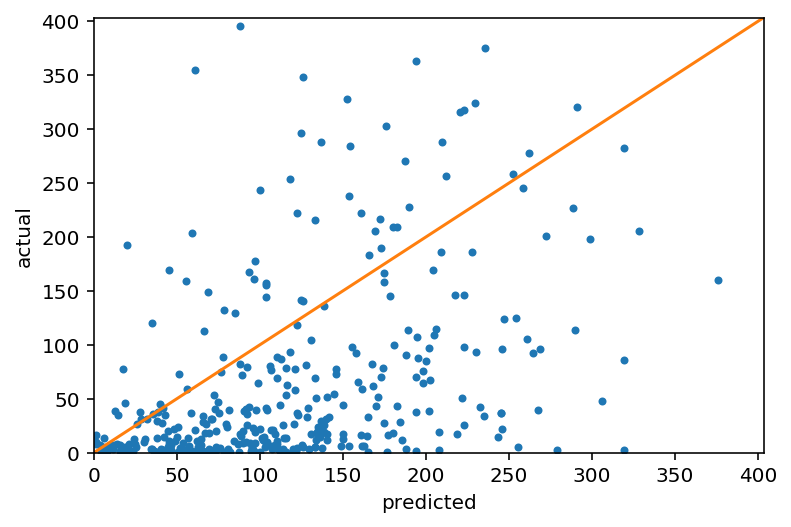

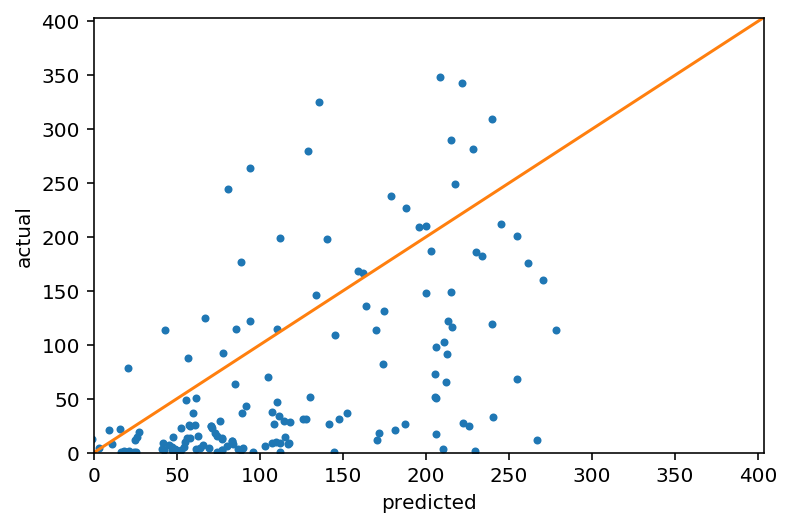

In [14]:
#linear regression with square loss

def prepare(original):    
    xs = original
    padder = [[1]]*len(xs)
    xs = np.hstack((padder, xs))
    return xs

xs = prepare(reduced.values)
ys = target.values

def cost(w):
    return np.sum((ys - np.dot(xs, w))**2)

nw = len(xs[0])

from scipy.optimize import minimize
np.random.seed(999)
res = minimize(cost, np.random.randn(nw))

predicted = np.dot(xs, res.x)
plt.title('Train')
compare_plot(np.log(predicted), np.log(ys))

print('train log loss', mse_loss(np.log(predicted), np.log(ys)))

plt.figure()
ys_test = target_test.values
xs_test = prepare(reduced_test)
predicted_test = np.dot(xs_test, res.x)

print('test log loss', mse_loss(np.log(predicted_test), np.log(ys_test)))
plt.title('Test')
compare_plot(np.log(predicted_test), np.log(ys_test))

print('train raw loss', mse_loss(predicted, ys))
print('test raw loss', mse_loss(predicted_test, ys_test))

res, res_test = plot_residual(np.log(predicted), np.log(ys), np.log(predicted_test), np.log(ys_test))
print(np.exp(np.std(res_test)))


plt.figure()
compare_raw_plot(predicted, ys) #log predicted vs log actual
plt.figure()
compare_raw_plot(predicted_test, ys_test) 

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in log
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in log


train loss 205.56069337855305
test loss 233.91887589456908


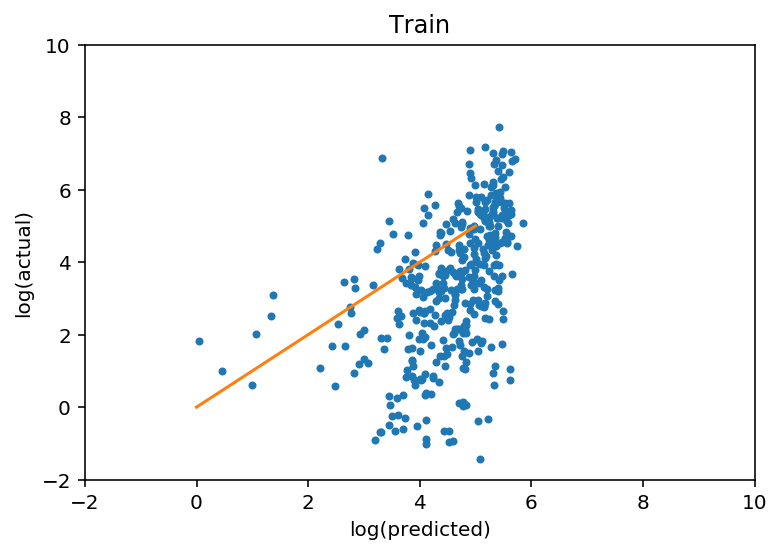

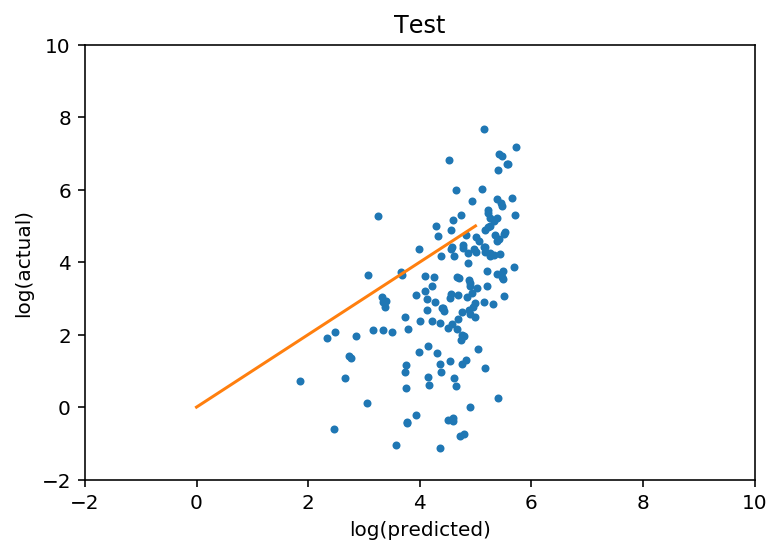

In [12]:
#linear regression with huber loss

def prepare(original):    
    xs = original
    padder = [[1]]*len(xs)
    xs = np.hstack((padder, xs))
    return xs

xs = prepare(reduced.values)
ys = target.values

def cost(w):
    return np.sum((ys - np.dot(xs, w))**2)

nw = len(xs[0])

from scipy.optimize import minimize
np.random.seed(999)
res = minimize(cost, np.random.randn(nw))

predicted = np.dot(xs, res.x)
plt.title('Train')
compare_plot(np.log(predicted), np.log(ys))

print('train loss', mse_loss(predicted, ys))

plt.figure()
ys_test = target_test.values
xs_test = prepare(reduced_test)
predicted_test = np.dot(xs_test, res.x)

print('test loss', mse_loss(predicted_test, ys_test))
plt.title('Test')
compare_plot(np.log(predicted_test), np.log(ys_test))

train loss 1.4855404118362208
test loss 1.5291566357889828


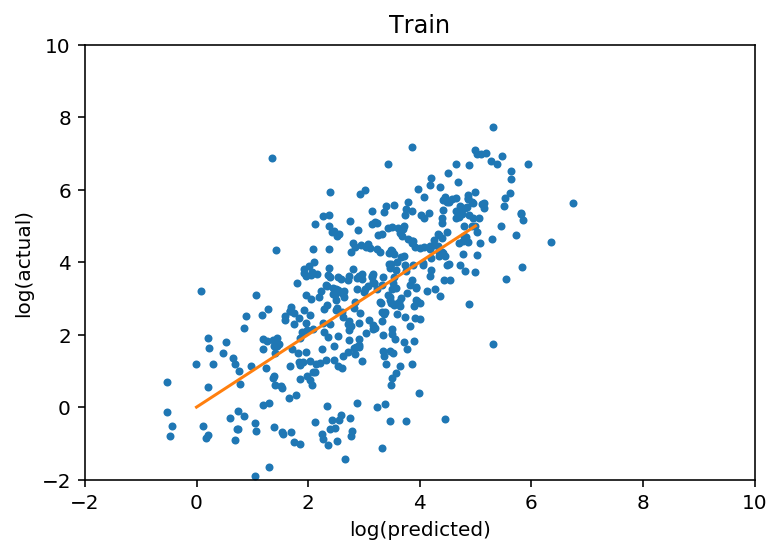

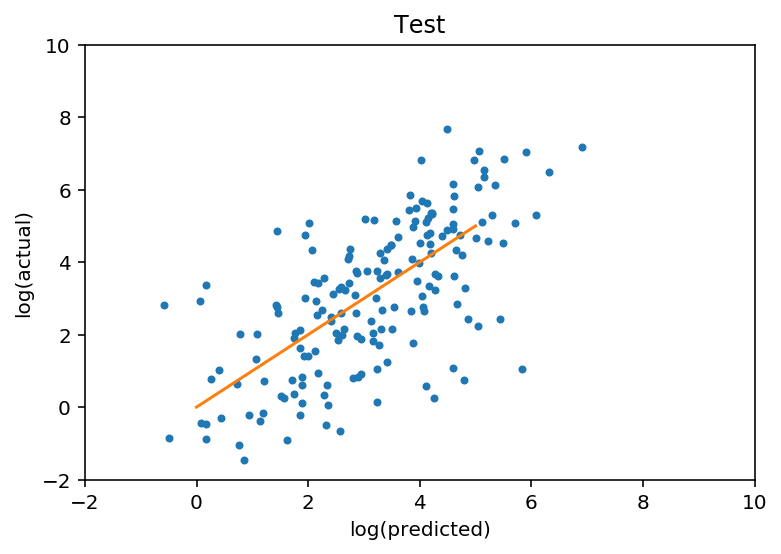

In [119]:
#try log linear # Motivation power law
from sklearn.preprocessing import PolynomialFeatures
def prepare(original):    
    xs = np.log(original)
    poly = PolynomialFeatures(2)
    xs = poly.fit_transform(xs)
    padder = [[1]]*len(xs)
    xs = np.hstack((padder, xs))
    return xs

xs = prepare(reduced.values)
ys = np.log(target.values)

def cost(w):
    return np.sum((ys - np.dot(xs, w))**2)

nw = len(xs[0])

from scipy.optimize import minimize
np.random.seed(999)
res = minimize(cost, np.random.randn(nw))

predicted = np.dot(xs, res.x)
plt.title('Train')
compare_plot(predicted, ys)

print('train loss', mse_loss(predicted, ys))

plt.figure()
ys_test = np.log(target_test.values)
xs_test = prepare(reduced_test)
predicted_test = np.dot(xs_test, res.x)

print('test loss', mse_loss(predicted_test, ys_test))
plt.title('Test')
compare_plot(predicted_test, ys_test)